<a href="https://colab.research.google.com/github/TheRadDani/pose_estimation_deployed_on_onnx/blob/main/Pose_Estimation_Model_Deployed_on_ONNX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade onnx onnxslim onnxruntime onnxruntime-extensions pillow --quiet

In [ ]:
%%writefile yolo_e2e.py
import numpy

from pathlib import Path
import onnxruntime_extensions


def get_yolo_model(version: int):
    # install yolov8
    from pip._internal import main as pipmain
    try:
        import ultralytics
    except ImportError:
        pipmain(['install', 'ultralytics'])
        import ultralytics
    pt_model = Path(f"yolov{version}.pt")
    model = ultralytics.YOLO(str(pt_model))  # load a pretrained model
    exported_filename = model.export(format="onnx")  # export the model to ONNX format
    assert exported_filename, f"Failed to export yolov{version}.pt to onnx"

def add_pre_post_processing_to_yolo(input_model_file: Path, output_model_file: Path):
    """Construct the pipeline for an end2end model with pre and post processing.
    The final model can take raw image binary as inputs and output the result in raw image file.

    Args:
        input_model_file (Path): The onnx yolo model.
        output_model_file (Path): where to save the final onnx model.
    """
    from onnxruntime_extensions.tools import add_pre_post_processing_to_model as add_ppp
    add_ppp.yolo_detection(input_model_file, output_model_file, "jpg", onnx_opset=19)


def run_inference(onnx_model_file: Path, model_v: str):
    import onnxruntime as ort
    import numpy as np

    providers = ['CPUExecutionProvider']
    session_options = ort.SessionOptions()
    session_options.register_custom_ops_library(onnxruntime_extensions.get_library_path())

    image = np.frombuffer(open('./wolves.jpg', 'rb').read(), dtype=np.uint8)
    session = ort.InferenceSession(str(onnx_model_file), providers=providers, sess_options=session_options)

    inname = [i.name for i in session.get_inputs()]
    inp = {inname[0]: image}

    output = session.run(['image_out'], inp)[0]
    output_filename = f'./result_{model_v}.jpg'
    open(output_filename, 'wb').write(output)

if __name__ == '__main__':
    # YOLO version. Tested with 5 and 8.
    version = "8n"
    onnx_model_name = Path(f"./yolov{version}.onnx")
    if not onnx_model_name.exists():
        print("Fetching original model...")
        get_yolo_model(version)

    onnx_e2e_model_name = onnx_model_name.with_suffix(suffix=".with_pre_post_processing.onnx")
    print("Adding pre/post processing...")
    add_pre_post_processing_to_yolo(onnx_model_name, onnx_e2e_model_name)
    print("Testing updated model...")
    run_inference(onnx_e2e_model_name, version)

Overwriting yolo_e2e.py


Adding pre/post processing...
Testing updated model...


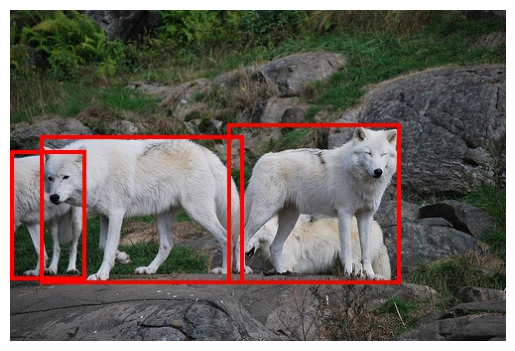

In [ ]:
import sys
! {sys.executable} yolo_e2e.py [--test_image ./wolves.jpg]
output_filename = "./result_8n.jpg"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(output_filename)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show();

In [ ]:
%%writefile yolov8_pose_e2e.py
import argparse
import onnx.shape_inference
import onnxruntime_extensions
from onnxruntime_extensions.tools.pre_post_processing import *
from pathlib import Path
from PIL import Image, ImageDraw


def _get_yolov8_pose_model(onnx_model_path: Path):
    # install yolov8
    from pip._internal import main as pipmain
    try:
        import ultralytics
    except ImportError:
        pipmain(['install', 'ultralytics'])
        import ultralytics

    pt_model = Path("yolov8n-pose.pt")
    model = ultralytics.YOLO(str(pt_model))  # load a pretrained model
    success = model.export(format="onnx")  # export the model to ONNX format
    assert success, "Failed to export yolov8n-pose.pt to onnx"
    import shutil
    shutil.move(pt_model.with_suffix('.onnx'), str(onnx_model_path))


def _get_model_and_info(input_model_path: Path):
    if not input_model_path.is_file():
        print(f"Fetching the model... {str(input_model_path)}")
        _get_yolov8_pose_model(input_model_path)

    print("Adding pre/post processing to the model...")
    model = onnx.load(str(input_model_path.resolve(strict=True)))

    model_with_shape_info = onnx.shape_inference.infer_shapes(model)

    model_input_shape = model_with_shape_info.graph.input[0].type.tensor_type.shape
    model_output_shape = model_with_shape_info.graph.output[0].type.tensor_type.shape

    # infer the input sizes from the model.
    w_in = model_input_shape.dim[-1].dim_value
    h_in = model_input_shape.dim[-2].dim_value
    assert w_in == 640 and h_in == 640  # expected values

    # output should be [1, 56, 8400].
    classes_masks_out = model_output_shape.dim[1].dim_value
    boxes_out = model_output_shape.dim[2].dim_value
    assert classes_masks_out == 56
    assert boxes_out == 8400

    return (model, w_in, h_in)


def _update_model(model: onnx.ModelProto, output_model_path: Path, pipeline: PrePostProcessor):
    """
    Update the model by running the pre/post processing pipeline
    @param model: ONNX model to update
    @param output_model_path: Filename to write the updated model to.
    @param pipeline: Pre/Post processing pipeline to run.
    """

    new_model = pipeline.run(model)
    print("Pre/post proceessing added.")

    # run shape inferencing to validate the new model. shape inferencing will fail if any of the new node
    # types or shapes are incorrect. infer_shapes returns a copy of the model with ValueInfo populated,
    # but we ignore that and save new_model as it is smaller due to not containing the inferred shape information.
    _ = onnx.shape_inference.infer_shapes(new_model, strict_mode=True)
    onnx.save_model(new_model, str(output_model_path.resolve()))
    print("Updated model saved.")


def _add_pre_post_processing_to_rgb_input(input_model_path: Path,
                                          output_model_path: Path,
                                          input_shape: List[Union[int, str]]):
    """
    Add pre and post processing with model input of RGB data.
    Pre-processing will convert the input to the correct height, width and data type for the model.
    Post-processing will select the best bounding boxes using NonMaxSuppression, and scale the selected bounding
    boxes and key-points to the original image size.

    @param input_model_path: Path to ONNX model.
    @param output_model_path: Path to write updated model to.
    @param input_shape: Input shape of RGB data. Must be 3D. First or last value must be 3 (channels first or last).
    """
    model, w_in, h_in = _get_model_and_info(input_model_path)

    if input_shape[0] == 3:
        layout = "CHW"
    elif input_shape[2] == 3:
        layout = "HWC"
    else:
        raise ValueError("Invalid input shape. Either first or last dimension must be 3.")

    onnx_opset = 18
    inputs = [create_named_value("rgb_data", onnx.TensorProto.UINT8, input_shape)]
    pipeline = PrePostProcessor(inputs, onnx_opset)

    if layout == "CHW":
        # use Identity so we have an output named RGBImageCHW
        # for ScaleNMSBoundingBoxesAndKeyPoints in the post-processing steps
        pre_processing_steps = [Identity(name="RGBImageCHW")]
    else:
        pre_processing_steps = [ChannelsLastToChannelsFirst(name="RGBImageCHW")]  # HWC to CHW

    pre_processing_steps += [
        # Resize to match model input. Uses not_larger as we use LetterBox to pad as needed.
        Resize((h_in, w_in), policy='not_larger', layout='CHW'),
        LetterBox(target_shape=(h_in, w_in), layout='CHW'),  # padding or cropping the image to (h_in, w_in)
        ImageBytesToFloat(),  # Convert to float in range 0..1
        Unsqueeze([0]),  # add batch, CHW --> 1CHW
    ]

    pipeline.add_pre_processing(pre_processing_steps)

    post_processing_steps = [
        Squeeze([0]),  # - Squeeze to remove batch dimension from [batch, 56, 8200] output
        Transpose([1, 0]),  # reverse so result info is inner dim
        # split the 56 elements into 4 for the box, score for the 1 class, and mask info (17 locations x 3 values)
        Split(num_outputs=3, axis=1, splits=[4, 1, 51]),
        # Apply NMS to select best boxes. iou and score values match
        # https://github.com/ultralytics/ultralytics/blob/e7bd159a44cf7426c0f33ed9b413ef4439505a03/ultralytics/models/yolo/pose/predict.py#L34-L35
        # thresholds are arbitrarily chosen. adjust as needed.
        SelectBestBoundingBoxesByNMS(iou_threshold=0.7, score_threshold=0.25, has_mask_data=True),
        # Scale boxes and key point coords back to original image. Mask data has 17 key points per box.
        (ScaleNMSBoundingBoxesAndKeyPoints(num_key_points=17, layout='CHW'),
         [
             # A default connection from SelectBestBoundingBoxesByNMS for input 0
             # A connection from original image to input 1
             # A connection from the resized image to input 2
             # A connection from the LetterBoxed image to input 3
             # We use the three images to calculate the scale factor and offset.
             # With scale and offset, we can scale the bounding box and key points back to the original image.
             utils.IoMapEntry("RGBImageCHW", producer_idx=0, consumer_idx=1),
             utils.IoMapEntry("Resize", producer_idx=0, consumer_idx=2),
             utils.IoMapEntry("LetterBox", producer_idx=0, consumer_idx=3),
        ]),
    ]

    pipeline.add_post_processing(post_processing_steps)

    _update_model(model, output_model_path, pipeline)


def _add_pre_post_processing_to_image_input(input_model_path: Path,
                                            output_model_path: Path,
                                            output_image_format: Optional[str]):
    """
    Add pre and post processing with model input of jpg or png image bytes.
    Pre-processing will convert the input to the correct height, width and data type for the model.
    Post-processing will select the best bounding boxes using NonMaxSuppression, and scale the selected bounding
    boxes and key-points to the original image size.

    The post-processing can alternatively return the original image with the bounding boxes drawn on it
    instead of the scaled bounding box and key point data.

    @param input_model_path: Path to ONNX model.
    @param output_model_path: Path to write updated model to.
    @param output_image_format: Optional. Specify 'jpg' or 'png' for the post-processing to return image bytes in that
                                format with the bounding boxes drawn on it.
                                Otherwise the model will return the scaled bounding boxes and key points.
    """
    model, w_in, h_in = _get_model_and_info(input_model_path)

    onnx_opset = 19
    inputs = [create_named_value("image_bytes", onnx.TensorProto.UINT8, ["num_bytes"])]
    pipeline = PrePostProcessor(inputs, onnx_opset)

    pre_processing_steps = [
        ConvertImageToBGR(name="BGRImageHWC"),  # jpg/png image to BGR in HWC layout
        ChannelsLastToChannelsFirst(name="BGRImageCHW"),  # HWC to CHW
        # Resize to match model input. Uses not_larger as we use LetterBox to pad as needed.
        Resize((h_in, w_in), policy='not_larger', layout='CHW'),
        LetterBox(target_shape=(h_in, w_in), layout='CHW'),  # padding or cropping the image to (h_in, w_in)
        ImageBytesToFloat(),  # Convert to float in range 0..1
        Unsqueeze([0]),  # add batch, CHW --> 1CHW
    ]

    pipeline.add_pre_processing(pre_processing_steps)

    # NonMaxSuppression and drawing boxes
    post_processing_steps = [
        Squeeze([0]),  # Squeeze to remove batch dimension from [batch, 56, 8200] output
        Transpose([1, 0]),  # reverse so result info is inner dim
        # split the 56 elements into the box, score for the 1 class, and mask info (17 locations x 3 values)
        Split(num_outputs=3, axis=1, splits=[4, 1, 51]),
        # Apply NMS to select best boxes. iou and score values match
        # https://github.com/ultralytics/ultralytics/blob/e7bd159a44cf7426c0f33ed9b413ef4439505a03/ultralytics/models/yolo/pose/predict.py#L34-L35
        # thresholds are arbitrarily chosen. adjust as needed
        SelectBestBoundingBoxesByNMS(iou_threshold=0.7, score_threshold=0.25, has_mask_data=True),
        # Scale boxes and key point coords back to original image. Mask data has 17 key points per box.
        (ScaleNMSBoundingBoxesAndKeyPoints(num_key_points=17, layout='CHW'),
         [
             # A default connection from SelectBestBoundingBoxesByNMS for input 0
             # A connection from original image to input 1
             # A connection from the resized image to input 2
             # A connection from the LetterBoxed image to input 3
             # We use the three images to calculate the scale factor and offset.
             # With scale and offset, we can scale the bounding box and key points back to the original image.
             utils.IoMapEntry("BGRImageCHW", producer_idx=0, consumer_idx=1),
             utils.IoMapEntry("Resize", producer_idx=0, consumer_idx=2),
             utils.IoMapEntry("LetterBox", producer_idx=0, consumer_idx=3),
        ]),
    ]

    if output_image_format:
        post_processing_steps += [
            # split out bounding box from keypoint data
            Split(num_outputs=2, axis=-1, splits=[6, 51], name="SplitScaledBoxesAndKeypoints"),
            # separate out the bounding boxes from the keypoint data to use the existing steps/custom op to draw the
            # bounding boxes.
            (DrawBoundingBoxes(mode='CENTER_XYWH', num_classes=1, colour_by_classes=True),
             [
                 utils.IoMapEntry("BGRImageHWC", producer_idx=0, consumer_idx=0),
                 utils.IoMapEntry("SplitScaledBoxesAndKeypoints", producer_idx=0, consumer_idx=1),
             ]),
            # Encode to jpg/png
            ConvertBGRToImage(image_format=output_image_format),
        ]

    pipeline.add_post_processing(post_processing_steps)

    print("Updating model ...")

    _update_model(model, output_model_path, pipeline)


def _run_inference(onnx_model_path: Path, model_input: str, model_outputs_image: bool, test_image: Path,
                   rgb_layout: Optional[str]):
    import onnxruntime as ort
    import numpy as np

    print(f"Running the model to validate output using {str(test_image)}.")

    providers = ['CPUExecutionProvider']
    session_options = ort.SessionOptions()
    session_options.register_custom_ops_library(onnxruntime_extensions.get_library_path())
    session = ort.InferenceSession(str(onnx_model_path), providers=providers, sess_options=session_options)

    input_name = [i.name for i in session.get_inputs()]
    if model_input == "image":
        image_bytes = np.frombuffer(open(test_image, 'rb').read(), dtype=np.uint8)
        model_input = {input_name[0]: image_bytes}
    else:
        rgb_image = np.array(Image.open(test_image).convert('RGB'))
        if rgb_layout == "CHW":
            rgb_image = rgb_image.transpose((2, 0, 1))  # Channels first
        model_input = {input_name[0]: rgb_image}

    model_output = ['image'] if model_outputs_image else ['nms_output_with_scaled_boxes_and_keypoints']
    outputs = session.run(model_output, model_input)

    if model_outputs_image:
        # jpg or png with bounding boxes draw
        image_out = outputs[0]
        from io import BytesIO
        s = BytesIO(image_out)
        Image.open(s).show()
    else:
        # manually draw the bounding boxes and skeleton just to prove it works
        skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9],
                    [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

        # open original image so we can draw on it
        input_image = Image.open(test_image).convert('RGB')
        input_image_draw = ImageDraw.Draw(input_image)

        scaled_nms_output = outputs[0]
        for result in scaled_nms_output:
            # split the 4 box coords, 1 score, 1 class (ignored), keypoints
            (box, score, _, keypoints) = np.split(result, (4, 5, 6))
            keypoints = keypoints.reshape((17, 3))

            # convert box from centered XYWH to co-ords and draw rectangle
            # NOTE: The pytorch model seems to output XYXY co-ords. Not sure why that's different.
            half_w = (box[2] / 2)
            half_h = (box[3] / 2)
            x0 = box[0] - half_w
            y0 = box[1] - half_h
            x1 = box[0] + half_w
            y1 = box[1] + half_h
            input_image_draw.rectangle(((x0, y0), (x1, y1)), outline='red', width=4)

            # draw skeleton
            # See https://github.com/ultralytics/ultralytics/blob/e7bd159a44cf7426c0f33ed9b413ef4439505a03/ultralytics/utils/plotting.py#L171
            for i, sk in enumerate(skeleton):
                # convert keypoint index in `skeleton` to 0-based index and get keypoint data for it
                keypoint1 = keypoints[sk[0] - 1]
                keypoint2 = keypoints[sk[1] - 1]
                pos1 = (int(keypoint1[0]), int(keypoint1[1]))
                pos2 = (int(keypoint2[0]), int(keypoint2[1]))
                conf1 = keypoint1[2]
                conf2 = keypoint2[2]
                if conf1 < 0.5 or conf2 < 0.5:
                    continue

                def coord_valid(coord):
                    x, y = coord
                    return 0 <= x < input_image.width and 0 <= y < input_image.height

                if coord_valid(pos1) and coord_valid(pos2):
                    input_image_draw.line((pos1, pos2), fill='yellow', width=2)

        output_filename = f'./result_pose_estimation.jpg'
        input_image.save(output_filename)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        """Add pre and post processing to the YOLOv8 POSE model. The model can be updated to take either
        jpg/png bytes as input (--input image), or RGB data (--input rgb).
        By default the post processing will scale the bounding boxes and key points to the original image.
    """)
    parser.add_argument("--onnx_model_path", type=Path, default="yolov8n-pose.onnx",
                        help="The ONNX YOLOv8 POSE model.")
    parser.add_argument("--updated_onnx_model_path", type=Path, required=False,
                        help="Filename to save the updated ONNX model to. If not provided default to the filename "
                        "from --onnx_model_path with '.with_pre_post_processing' before the '.onnx' "
                        "e.g. yolov8n-pose.onnx -> yolov8n-pose.with_pre_post_processing.onnx")
    parser.add_argument("--input", choices=("image", "rgb"), default="image",
                        help="Desired model input format. Image bytes from jpg/png or RGB data.")
    parser.add_argument("--input_shape",
                        type=lambda x: [int(dim) if dim.isnumeric() else dim for dim in x.split(",")],
                        required=False,
                        help="Shape of RGB input if input is 'rgb'. Provide a comma separated list of 3 dimensions. "
                             "Symbolic dimensions are allowed. Either the first or last dimension must be 3 to infer "
                             "if layout is HWC or CHW. "
                             "examples: channels first with symbolic dims for height and width: --input_shape 3,H,W "
                             "or channels last with fixed input shape: --input_shape 384,512,3")
    parser.add_argument("--output_image", choices=("jpg", "png"), required=False,
                        help="OPTIONAL. If the input is an image, instead of outputting the scaled bounding boxes and "
                             "key points the model will draw the bounding boxes on the original image, convert to the "
                             "specified format, and output the updated image bytes. The scaled key points for each "
                             "selected bounding box will also be a model output."
                             "NOTE: it will NOT draw the key points as there's no custom operator to handle that.")
    parser.add_argument("--run_model", action='store_true',
                        help="Run inference on the model to validate output.")
    parser.add_argument("--test_image", type=Path, default="data/stormtroopers.jpg",
                        help="JPG or PNG image to run model with.")

    args = parser.parse_args()

    if args.output_image and args.input == "rgb":
        raise argparse.ArgumentError(args.output_image, "output_image argument can only be used if input is 'image'")

    if args.input_shape and len(args.input_shape) != 3:
        raise argparse.ArgumentError(args.input_shape, "Shape of RGB input must have 3 dimensions.")

    updated_model_path = (args.updated_onnx_model_path
                          if args.updated_onnx_model_path
                          else args.onnx_model_path.with_suffix(suffix=".with_pre_post_processing.onnx"))

    # default output is the scaled non-max suppression data which matches the original model.
    # each result has bounding box (4), score (1), class (1), key points (17 x 3) = 57 elements
    # bounding box is centered XYWH format.
    # alternative is to output the original image with the bounding boxes but no key points drawn.
    if args.input == "rgb":
        print("Updating model with RGB data as input.")
        _add_pre_post_processing_to_rgb_input(args.onnx_model_path, updated_model_path, args.input_shape)
        rgb_layout = "CHW" if args.input_shape[0] == 3 else "HWC"
    else:
        assert(args.input == "image")
        print("Updating model with jpg/png image bytes as input.")
        _add_pre_post_processing_to_image_input(args.onnx_model_path, updated_model_path, args.output_image)
        rgb_layout = None

    if args.run_model:
        _run_inference(updated_model_path, args.input, args.output_image is not None, args.test_image, rgb_layout)


Overwriting yolov8_pose_e2e.py


In [ ]:
import sys
! {sys.executable} yolov8_pose_e2e.py

Updating model with jpg/png image bytes as input.
Adding pre/post processing to the model...
Updating model ...
Pre/post proceessing added.
Updated model saved.


Updating model with jpg/png image bytes as input.
Adding pre/post processing to the model...
Updating model ...
Pre/post proceessing added.
Updated model saved.
Running the model to validate output using /content/10887.jpg.
Displaying original image with bounding boxes and skeletons.


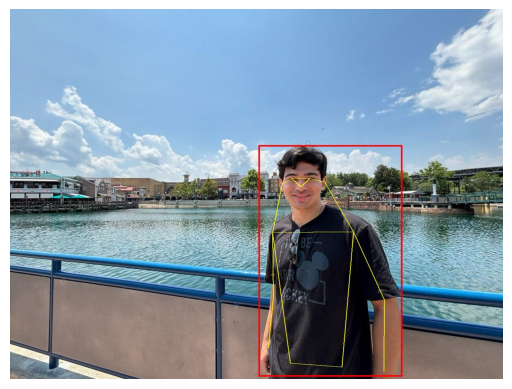

In [ ]:
import sys
! {sys.executable} yolov8_pose_e2e.py --test_image /content/10887.jpg --run_model
output_filename = "./result_pose_estimation.jpg"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(output_filename)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show();